# Pixel Ratio Analysis Notebook: Histogram of White Pixel Ratios by Label

**Objective:**  
Analyze the white pixel distribution in the Dot and Silhouette datasets to understand whether pixel ratio is a strong indicator of numerosity. This helps assess if the networks could be relying on low-level pixel statistics rather than abstract quantity concepts.

- Load the pre-saved Dot and Silhouette datasets from .pt files.

- Compute the white pixel ratio (number of white pixels / total pixels) for each image.

- Group pixel ratios by ground truth label (Few, Medium, Many).

- Plot histograms showing pixel ratio distributions for each label class.

**Note:**  
Make sure that the files **`train_dataset.pt`,** **`val_dataset.pt`**, **`test_dataset.pt`** and **`final_numerosity_model.pt`** are in your working directory.



# Environment Setup and Seed Setting

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# Load Saved Datasets

In [4]:
from torch.utils.data import Dataset

class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

from torch.utils.data.dataset import Subset
import torch.serialization

torch.serialization.add_safe_globals([Subset])

# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 32  # default value; can be tuned later
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 3500
Validation Dataset Size: 750
Test Dataset Size: 750


# Histogram generation

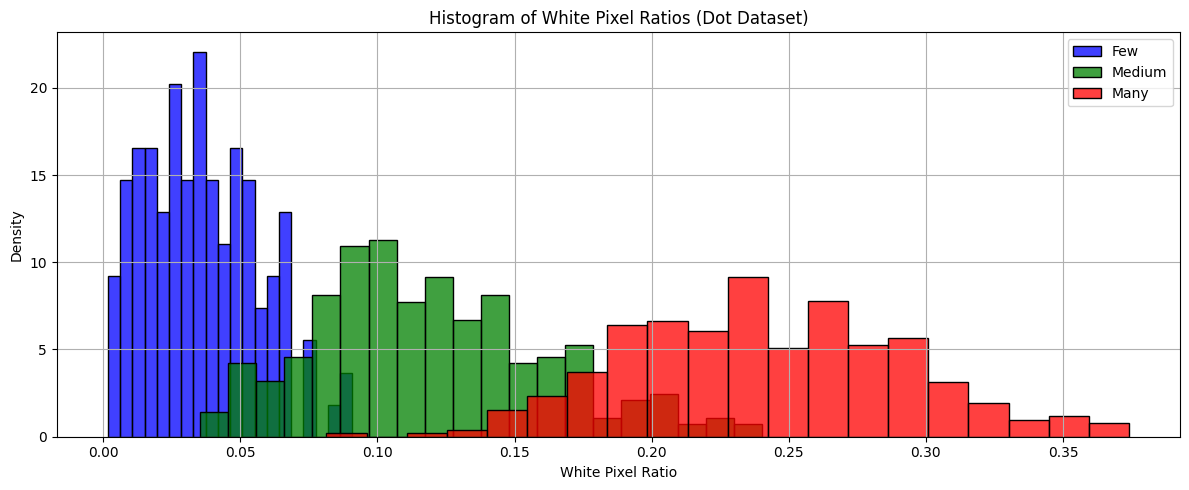

In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the test dataset
test_dataset = torch.load("test_dataset.pt", weights_only=False)

# Initialize lists for each label group
ratios_few = []
ratios_medium = []
ratios_many = []

# Compute white pixel ratio for each image
for img, label in test_dataset:
    img_np = img.squeeze().numpy()  # convert tensor to 2D numpy array
    white_ratio = np.sum(img_np > 0.5) / img_np.size  # thresholding to handle float values
    if label == 0:
        ratios_few.append(white_ratio)
    elif label == 1:
        ratios_medium.append(white_ratio)
    elif label == 2:
        ratios_many.append(white_ratio)

# Plotting histograms
plt.figure(figsize=(12, 5))
sns.histplot(ratios_few, bins=20, kde=False, color='blue', label='Few', stat="density")
sns.histplot(ratios_medium, bins=20, kde=False, color='green', label='Medium', stat="density")
sns.histplot(ratios_many, bins=20, kde=False, color='red', label='Many', stat="density")

plt.title("Histogram of White Pixel Ratios (Dot Dataset)")
plt.xlabel("White Pixel Ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()